<a href="https://colab.research.google.com/github/aryan-cs/poker-like-games/blob/discrete-poker/discrete_poker_games.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# -1. Preface
While the paper designates letters to each player (Player A, Player B), the code makes use of integers for readability.

`P1`, `p1_foo` → Player A, Property of Player A

`P2`, `p2_foo` → Player B, Property of Player B

# 0. Setup
Run this cell to set up some helpful tools.

In [ ]:
import time
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
from rich.console import Console
from rich.table import Table

log_data = []
P1 = True
P2 = True

RED = "#ff2684"
BLUE = "#19beff"
WHITE = "#ebebeb"
GRAY = "#858585"

# First player has n options, second player has n - 1 options (picking without replacement)
def nCr(n): return n * (n - 1) # / 2

# Saving -- irrelevant
def log(p1_cutoff, p2_cutoff, p1_expected_payout, p2_expected_payout, time_taken, verbose=True):
    log_data.append({
        'p1_cutoff': p1_cutoff,
        'p2_cutoff': p2_cutoff,
        'p1_expected_payout': p1_expected_payout,
        'p2_expected_payout': p2_expected_payout,
        'time_taken': time_taken
    })

    message = '''
P1 Cutoff: {0}
P2 Cutoff: {1}
P1 Payout: {2:.5f}
P2 Payout: {3:.5f}
Executed in {4:.5f} seconds
'''.format(p1_cutoff,
            p2_cutoff,
            p1_expected_payout,
            p2_expected_payout,
            time_taken)

    if verbose: boxed(message)

# Visual appeal -- irrelevant
def boxed(text):
    lines = text.splitlines()
    if lines and lines[0] == "": lines = lines[1:]
    if not lines: return

    max_width = max(map(len, lines))

    print("┌" + "─" * (max_width + 2) + "┐")
    for line in lines:
      print(f"│ {line.ljust(max_width)} │")
    print("└" + "─" * (max_width + 2) + "┘")

# Graphing -- irrelevant
def graph_scatter_3d(p1=False, p2=False):
    df = pd.DataFrame(log_data)
    fig = go.Figure()

    if p1:
        fig.add_trace(go.Scatter3d(
            x=df['p1_cutoff'],
            y=df['p2_cutoff'],
            z=df['p1_expected_payout'],
            mode='markers',
            marker=dict(color='blue', size=4),
            name='Player 1'
        ))

    if p2:
        fig.add_trace(go.Scatter3d(
            x=df['p1_cutoff'],
            y=df['p2_cutoff'],
            z=df['p2_expected_payout'],
            mode='markers',
            marker=dict(color='red', size=4),
            name='Player 2'
        ))

    fig.update_layout(
        title='Payouts as a function of Cutoffs | Scatter',
        scene=dict(
            xaxis_title='α',
            yaxis_title='β',
            zaxis_title='Payout'
        ),
        showlegend=True
    )

    fig.show()

# Graphing -- irrelevant
def graph_contour_3d(p1=False, p2=False):
    df = pd.DataFrame(log_data).groupby(['p1_cutoff', 'p2_cutoff'], as_index=False).mean()
    fig = go.Figure()

    x = np.unique(df['p1_cutoff'])
    y = np.unique(df['p2_cutoff'])
    X, Y = np.meshgrid(x, y)

    if p1:
        Z1 = df.pivot_table(
            index='p2_cutoff',
            columns='p1_cutoff',
            values='p1_expected_payout').values
        fig.add_trace(go.Surface(x=X, y=Y, z=Z1,
                                 colorscale='Blues',
                                 opacity=0.9,
                                 name="Player 1 Payout"))

    if p2:
        Z2 = df.pivot_table(
            index='p2_cutoff',
            columns='p1_cutoff',
            values='p2_expected_payout').values
        fig.add_trace(go.Surface(x=X, y=Y, z=Z2,
                                 colorscale='Reds',
                                 opacity=0.9,
                                 name="Player 2 Payout"))

    fig.update_layout(
        title='Eᵢ(α, β)',
        scene=dict(
            xaxis_title='α',
            yaxis_title='β',
            zaxis_title='Payout'
        ),
        showlegend=True
    )

    fig.show()

def graph_2d(p1=False, p2=False):
    df = pd.DataFrame(log_data).groupby(['p1_cutoff', 'p2_cutoff'], as_index=False).mean()

    plt.figure(figsize=(10, 6))

    if p1:
        # Use the BLUE variable for Player 1
        plt.plot(df['p1_cutoff'], df['p1_expected_payout'], label='Player 1 Payout', color=BLUE, linewidth=2)

    if p2:
        # Use the RED variable for Player 2
        plt.plot(df['p1_cutoff'], df['p2_expected_payout'], label='Player 2 Payout', color=RED, linewidth=2)

    # Adding title and labels
    plt.title('Payouts as a function of Cutoffs | Level Curve', fontsize=16)
    plt.xlabel('Player Cutoff', fontsize=14)
    plt.ylabel('Expected Payout', fontsize=14)

    # Add a legend
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()

# Displaying payoff matrix -- irrelevant
def expected_payoffs_table(p1=False, p2=False):
    if p1 and p2:
        boxed("Please use only one flag per table.")
        return

    console = Console()
    df = pd.DataFrame(log_data).groupby(['p1_cutoff', 'p2_cutoff'], as_index=False).mean()

    if p1:
        pivot = df.pivot(index='p1_cutoff', columns='p2_cutoff', values='p1_expected_payout')
        title = "E(c1, c2) for P1 | " + str(n) + " x " + str(n)
    elif p2:
        pivot = df.pivot(index='p1_cutoff', columns='p2_cutoff', values='p2_expected_payout')
        title = "E(c1, c2) for P2 | " + str(n) + " x " + str(n)
    else:
        boxed("Please specify either p1=True or p2=True")
        return

    table = Table(title=title, show_lines=True, padding=(0, 1), collapse_padding=True)
    table.add_column("C", style=WHITE, justify="right")

    for col in pivot.columns:
        table.add_column(f"{col}", justify="right")

    def format_value(val):
        if pd.isnull(val):
            return f"[#ebebeb]-[/#ebebeb]"
        color = BLUE if val > 0 else RED if val < 0 else WHITE
        formatted_val = f"{int(val)}" if val == int(val) else f"{val:.5f}"
        return f"[{color}]{formatted_val}[/{color}]"

    for idx, row in pivot.iterrows():
        idx_formatted = f"{int(idx)}" if idx == int(idx) else f"{idx:.2f}"
        table_row = [idx_formatted] + [format_value(val) for val in row]
        table.add_row(*table_row, end_section=True)

    console.print(table)

# Exporting -- irrelevant
def save():
    df = pd.DataFrame(log_data)
    df.to_csv('data.csv', index=False)


# 1. Simulation of Opposing Cutoff Strategies
Simulating payoffs for various cutoff combinations.

┌───────────────────────────────────────────┐
│ Executed all iterations in 0.361 seconds. │
└───────────────────────────────────────────┘


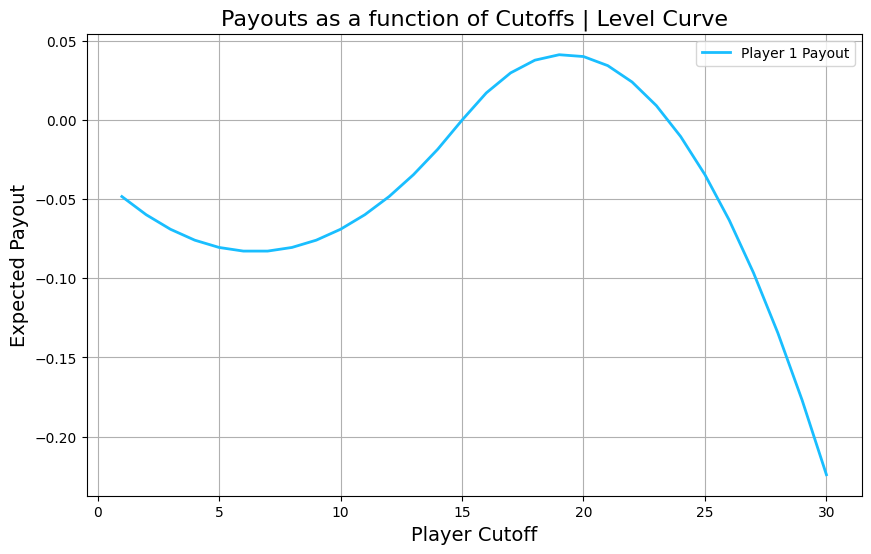

In [ ]:
#@title { vertical-output: true }

"""

  Example n values:
    n = 3: Ace/King/Queen
    n = 6: Dice
    n = 13: Full Suit Poker
    n = 1000: Roughly continuous

  Iterating for cutoff ranges of [1, test_range]

"""
n = 30
test_range = n
p1_expected_payout, p2_expected_payout = 0, 0
trials = nCr(n)

def test_cutoffs(p1_cutoff, p2_cutoff):

  start_time = time.time()

  global p1_expected_payout
  global p2_expected_payout

  p1_expected_payout = 0
  p2_expected_payout = 0

  # Testing every possible 'card' for Player A and Player B
  for p1_card in range(1, n + 1):
    for p2_card in range(1, n + 1):

      if p1_card == p2_card: continue

      # Player A in betting region, Player B in betting region
      if p1_card >= p1_cutoff and p2_card >= p2_cutoff:

        # Case BBW
        if p1_card > p2_card:       # Player A wins showdown
          p1_expected_payout += 2
          p2_expected_payout -= 2

        # Case BBL
        else:                       # Player B wins showdown
          p1_expected_payout -= 2
          p2_expected_payout += 2

      # Player A in folding region, Player B in folding region
      elif p1_card < p1_cutoff and p2_card < p2_cutoff:

        # Case FFW
        if p1_card > p2_card:       # Player A wins showdown
          p1_expected_payout += 1
          p2_expected_payout -= 1

        # Case FFL
        else:                       # Player B wins showdown
          p1_expected_payout -= 1
          p2_expected_payout += 1

      # Player A in betting region, Player B in folding region | Player B forfeits, Player A wins by default
      elif p1_card >= p1_cutoff:

        # Case BFW
        p1_expected_payout += 1
        p2_expected_payout -= 1

      # Player A in folding region, Player B in betting region | Player A forfeits, Player B wins by default
      elif p2_card >= p2_cutoff:

        # Case FBL
        p1_expected_payout -= 1
        p2_expected_payout += 1

  return time.time() - start_time

log_data = []
start_time = time.time()

'''
  Testing all possible cutoffs
  A cutoff is defined as the minimum value a player must have in order to bet
'''
for p1_test_cutoff in range(1, test_range + 1):
  for p2_test_cutoff in range(1, test_range + 1):
    # timeTaken = test_cutoffs(p1_test_cutoff, p2_test_cutoff)
    timeTaken = test_cutoffs(p1_test_cutoff, n / 2)
    log(p1_test_cutoff,
        p2_test_cutoff,
        p1_expected_payout / trials,
        p2_expected_payout / trials,
        # p1_expected_payout,
        # p2_expected_payout,
        timeTaken,
        verbose=False)

boxed(f"Executed all iterations in {round(time.time() - start_time, 3)} seconds.\n")

# Add flags as necessary (P1, P2)
# graph_scatter_3d(P1)
# graph_contour_3d(P1)
graph_2d(P1)
# expected_payoffs_table(P1)
save()

# 2. Determining if Cutoff Strategy is Dominiant

This code iterates over all 2^n pure strategies for both players and checks to see if the Cutoff Strategy payout yields is greater than or equal to the payout by any other strategy. We find that the Cutoff Strategy is ***not*** a dominant strategy.


In [ ]:
#@title { vertical-output: true }


import itertools

n = 3

def indices_of_max(data):
    if not data: return []
    max_value = max(data)
    return [index for index, value in enumerate(data) if value == max_value]

def test_betting_strategies(p1_hands, p2_hands):
    p1_payouts = []
    p1_strategies = []

    for p2_betting_set in p2_hands:
        p1_payouts.clear()
        p1_strategies.clear()

        for p1_betting_set in p1_hands:
            p1_expected_payout = 0
            p2_expected_payout = 0

            for p1_card in range(1, n + 1):
                for p2_card in range(1, n + 1):
                    if p1_card == p2_card:
                        continue

                    if (p1_card in p1_betting_set) and (p2_card in p2_betting_set):
                        if p1_card > p2_card:
                            p1_expected_payout += 2
                            p2_expected_payout -= 2
                        else:
                            p1_expected_payout -= 2
                            p2_expected_payout += 2

                    elif (p1_card not in p1_betting_set) and (p2_card not in p2_betting_set):
                        if p1_card > p2_card:
                            p1_expected_payout += 1
                            p2_expected_payout -= 1
                        else:
                            p1_expected_payout -= 1
                            p2_expected_payout += 1

                    elif (p1_card in p1_betting_set) and (p2_card not in p2_betting_set):
                        p2_expected_payout -= 1
                        p1_expected_payout += 1

                    elif (p1_card not in p1_betting_set) and (p2_card in p2_betting_set):
                        p2_expected_payout += 1
                        p1_expected_payout -= 1

            p1_strategies.append(p1_betting_set)
            p1_payouts.append(p1_expected_payout)

        p1_maxes = indices_of_max(p1_payouts)
        bad_strategies = []
        bad_payouts = 2
        is_possible = False

        for index in p1_maxes:
            strat = list(p1_strategies[index])
            works = all(strat[len(strat) - i - 1] == n - i for i in range(len(strat)))

            if works:
                is_possible = True
            else:
                bad_strategies = p1_strategies[index]
                bad_payouts = p1_payouts[index]

        # Print the optimal strategy for Player A given Player B's strategy
        # boxed(
        #     "P1 Strat: " + str(p1_strategies[index]) + "\n" +
        #     "Payout: " + str(p1_payouts[index])
        # )

        if not is_possible:
            boxed(
              "P2 Strat: " + str(p2_betting_set) + "\n"
              "Payout: " + str(bad_payouts) + "\n"
              "Not Cutoff P1 Strat: " + str(bad_strategies) + "\n"
            )

# Example usage
p1_hands = [[], [1], [2], [3], [1, 2], [1, 3], [2, 3], [1, 2, 3]]
p2_hands = [[], [1], [2], [3], [1, 2], [1, 3], [2, 3], [1, 2, 3]]

test_betting_strategies(p1_hands, p2_hands)


┌─────────────────────────────┐
│ P2 Strat: [3]               │
│ Payout: 1                   │
│ Not Cutoff P1 Strat: [1, 3] │
└─────────────────────────────┘


# 4. Minimax Optimization
Optimizing for Player A given Player A's hand & Player B's best response strategy.

In [ ]:
#@title { vertical-output: true }

import itertools

n = 3

p1_test_betting_set = [1, 2, 3]

def subsets_size_n(s, N):
    return list(itertools.combinations(s, N))

def expected_payout(p1_betting_set, p2_betting_set):
    p1_expected_payout = 0
    p2_expected_payout = 0

    for p1_card in range(1, n + 1):
        for p2_card in range(1, n + 1):
            if p1_card == p2_card:
                continue

            if (p1_card in p1_betting_set) and (p2_card in p2_betting_set):
                if p1_card > p2_card:
                    p1_expected_payout += 2
                    p2_expected_payout -= 2
                else:
                    p1_expected_payout -= 2
                    p2_expected_payout += 2

            elif (p1_card not in p1_betting_set) and (p2_card not in p2_betting_set):
                if p1_card > p2_card:
                    p1_expected_payout += 1
                    p2_expected_payout -= 1
                else:
                    p1_expected_payout -= 1
                    p2_expected_payout += 1

            elif (p1_card in p1_betting_set) and (p2_card not in p2_betting_set):
                p1_expected_payout += 1
                p2_expected_payout -= 1

            elif (p1_card not in p1_betting_set) and (p2_card in p2_betting_set):
                p1_expected_payout -= 1
                p2_expected_payout += 1

    return p1_expected_payout, p2_expected_payout

def find_best_strategy_for_p2(p1_betting_set):
    best_p2_strategy = None
    best_payout = float('-inf')

    for N in range(0, n + 1):
        for p2_betting_set in subsets_size_n(range(1, n + 1), N):
            _, p2_payout = expected_payout(set(p1_betting_set), set(p2_betting_set))
            if p2_payout > best_payout:
                best_payout = p2_payout
                best_p2_strategy = list(p2_betting_set)

    return best_p2_strategy

def find_best_strategy_for_p1(p2_betting_set, p1_original_betting_set):
    best_p1_strategy = None
    best_payout = float('-inf')

    for N in range(0, len(p1_original_betting_set) + 1):
        for p1_betting_set in subsets_size_n(p1_original_betting_set, N):
            p1_payout, _ = expected_payout(set(p1_betting_set), set(p2_betting_set))
            if p1_payout > best_payout:
                best_payout = p1_payout
                best_p1_strategy = list(p1_betting_set)

    return best_p1_strategy

def minimax_test(p1_betting_set):
    best_p2_strategy = find_best_strategy_for_p2(p1_betting_set)
    best_p1_strategy = find_best_strategy_for_p1(best_p2_strategy, p1_betting_set)

    boxed(
        "Player A's betting set: " + str(p1_betting_set) + "\n"
        "Player B BR | Player A's betting set: " + str(best_p2_strategy) + "\n"
        "Player A BR | Player B BR: " + str(best_p1_strategy) + "\n"
    )

minimax_test(p1_test_betting_set)

┌──────────────────────────────────────────────┐
│ Player A's betting set: [1, 2, 3]            │
│ Player B BR | Player A's betting set: [2, 3] │
│ Player A BR | Player B BR: [3]               │
└──────────────────────────────────────────────┘


# 3D Graph


In [19]:
#@title { vertical-output: true }

import numpy as np
import plotly.graph_objects as go

n = 3  # The greater the n, the smaller the maximum expected profit
k = 20  # Number of datapoints (alpha and beta values) to draw between [0, 1]

# (-3αb + α² + 2β² - 2β + 2α - nβ + nα) / (n (n - 1)), {β > α}
def E_bga(alpha, beta, n):
    return ((-3 * alpha * beta ) + (alpha * alpha) + (2 * beta * beta) - (2 * beta) + (2 * alpha) - (n * beta) + (n * alpha)) / (n * (n - 1))

# (-3αb + β² + 2α² - 2α + 2β - nα + nβ) / (n (n - 1)), {α > β}
def E_agb(alpha, beta, n):
    return ((3 * alpha * beta) - (beta * beta) - (2 * alpha * alpha) + (2 * alpha) - (2 * beta) + (n * alpha) - (n * beta)) / (n * (n - 1))

# Generate k values in the range [0, 1] and scale them up to [0, n] for Player A cutoffs
A = np.linspace(0, 1, k) * n

# Generate k values in the range [0, 1] and scale them up to [0, n] for Player B cutoffs
B = np.linspace(0, 1, k) * n

# Cross the Player A & Player B cutoffs to create a k x k grid of every possible cutoff pairing
Alpha, Beta = np.meshgrid(A, B)

# Compute the expected payouts while analyzing both BGA (β > α) and AGB (α > β) cases
E_P1 = np.where(Alpha > Beta, E_agb(Alpha, Beta, n), E_bga(Alpha, Beta, n))

# Plot both curves on the same plot
fig = go.Figure()

# # Plot the surface
# fig.add_trace(go.Surface(
#     x=Alpha,
#     y=Beta,
#     z=E_P1,
#     colorscale='Viridis',
#     showscale=False,
#     opacity=0.9))

# Plot the lattice
fig.add_trace(go.Scatter3d(
    x=Alpha.flatten(),
    y=Beta.flatten(),
    z=E_P1.flatten(),
    mode='markers',
    marker=dict(size=4, color=E_P1.flatten(), colorscale='Viridis', opacity=0.9)
))

# Update layout with titles and axis labels
fig.update_layout(
    # title="E₁(α, β)",
    width=800,
    height=600,
    scene=dict(
        xaxis=dict(title="A", showticklabels=False, showgrid=False),
        yaxis=dict(title="B", showticklabels=False, showgrid=False),
        zaxis=dict(title="E₁(α, β)", showticklabels=False, showgrid=False)
    ),
    showlegend=False
)

fig.show()


# Level Curve Graphs

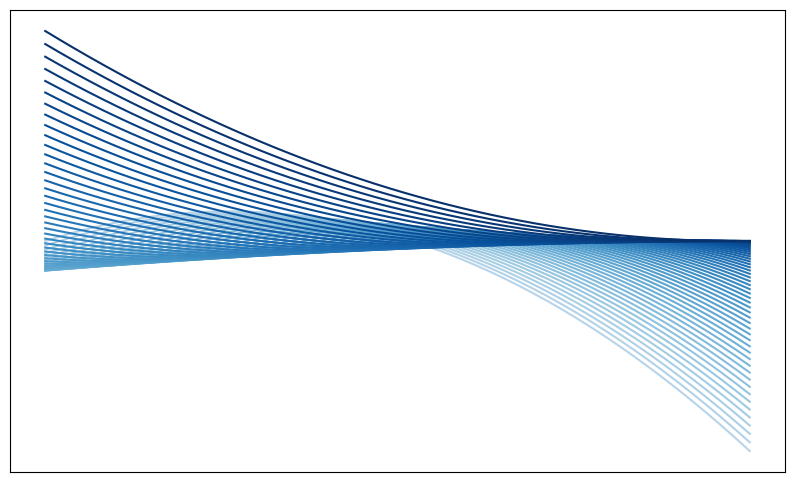

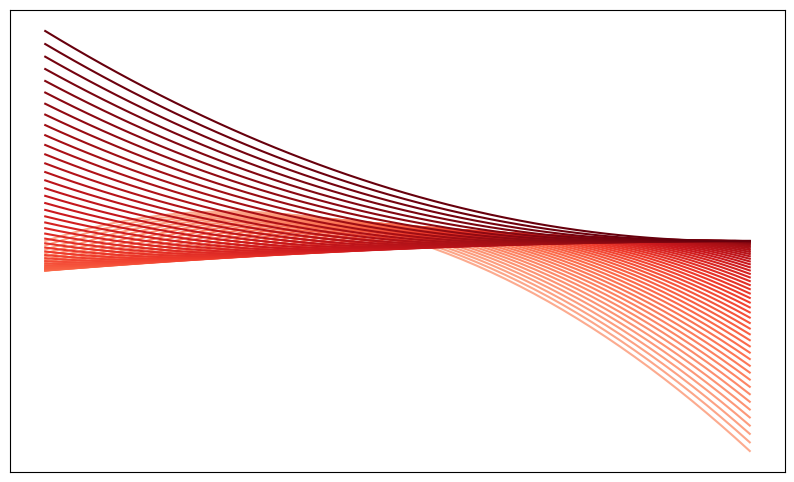

In [25]:
#@title { vertical-output: true }

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

N = 50

def E1(alpha, beta, n):

  # (-3αb + α² + 2β² - 2β + 2α - nβ + nα) / (n (n - 1)), {β > α}
  if beta > alpha:
    return ((-3 * alpha * beta )+ (alpha * alpha) + (2 * beta * beta) - (2 * beta) + (2 * alpha) - (n * beta) + (n * alpha)) / (n * (n - 1))

  # (-3αb + β² + 2α² - 2α + 2β - nα + nβ) / (n(n-1)), {α > β}
  elif alpha > beta: return ((3 * alpha * beta) - (beta * beta) - (2 * alpha * alpha) + (2 * alpha) - (2 * beta) + (n * alpha) - (n * beta)) / (n * (n - 1))

  else: return 0

def E2(alpha, beta, n):
  return -1 * E1(alpha, beta, n)

  # (-3αb + α² + 2β² - 2β + 2α - nβ + nα) / (n (n - 1)), {β > α}
  if beta > alpha:
    return ((-3 * alpha * beta )+ (alpha * alpha) + (2 * beta * beta) - (2 * beta) + (2 * alpha) - (n * beta) + (n * alpha)) / (n * (n - 1))

  # (-3αb + β² + 2α² - 2α + 2β - nα + nβ) / (n (n - 1)), {α > β}
  elif alpha > beta: return ((-3 * alpha * beta) + (beta * beta) + (2 * alpha * alpha) - (2 * alpha) + (2 * beta) - (n * alpha) + (n * beta)) / (n * (n - 1))

  else: return 0

def level_curves(n, P1=True, P2=False):
    values = np.arange(1, n + 1, 1)
    plt.figure(figsize=(10, 6))

    if P1:
        colors = cm.Blues(np.linspace(0.3, 1, n))
        for beta, color in zip(range(1, n + 1), colors):
            results = [E1(alpha, beta, n) for alpha in values]
            plt.plot(values, results, linestyle='-', color=color, label=f'Beta = {beta}')
        plt.xlabel('A', fontsize=14)
        # plt.title('Expected Value as a function of Player A Cutoff', fontsize=16)

    if P2:
        colors = cm.Reds(np.linspace(0.3, 1, n))
        for alpha, color in zip(range(1, n + 1), colors):
            results = [E2(alpha, beta, n) for beta in values]
            plt.plot(values, results, linestyle='-', color=color, label=f'Alpha = {alpha}')
        plt.xlabel('B', fontsize=14)
        # plt.title('Expected Value as a function of Player B Cutoff', fontsize=16)

    # plt.ylabel('Expected Value', fontsize=14)

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')

    plt.show()

level_curves(n=N, P1=True, P2=False)
level_curves(n=N, P1=False, P2=True)
# level_curves(n=N, P1=True, P2=True)